In [104]:

!pip show scikit-learn

Name: scikit-learn
Version: 1.3.2
Summary: A set of python modules for machine learning and data mining
Home-page: http://scikit-learn.org
Author: 
Author-email: 
License: new BSD
Location: /opt/conda/lib/python3.10/site-packages
Requires: joblib, numpy, scipy, threadpoolctl
Required-by: autogluon.core, autogluon.features, autogluon.multimodal, autogluon.tabular, fastai, lightgbm, mlforecast, pytorch-metric-learning, seqeval


In [105]:
!pip install scikit-learn

## Download the data from the S3 bucket <a name="data-download"></a>

In [106]:
#### Downloading the titles dataset available in the s3 bucket to the sagemaker notebook.
#### Import required libraries

import pandas as pd
import boto3
from sklearn.preprocessing import StandardScaler

import sagemaker
from sagemaker import get_execution_role

role = get_execution_role()
bucket_name='movie-recommendation-s3'

title_basic = 'csv_files/csv_files/title.basics.tsv'

s3 = boto3.client('s3')
obj = s3.get_object(Bucket = bucket_name,Key = title_basic)

df_title_basic = pd.read_table(obj['Body'])
df_title_basic = df_title_basic.dropna()

df_title_basic.head()

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


/tmp/ipykernel_95/2157222536.py:19: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df_title_basic = pd.read_table(obj['Body'])


,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short"
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,\N,4,"Animation,Comedy,Romance"
3,tt0000004,short,Un bon bock,Un bon bock,0,1892,\N,12,"Animation,Short"
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,\N,1,"Comedy,Short"


## Data Cleanup <a name="Data Preprocessing"></a>

In [107]:

#  Filter the dataset by movies 
title_basics_processed = df_title_basic[df_title_basic['titleType']=='movie']

# Removing unneccesary columns - endYear, titleType
title_basics_processed = title_basics_processed.drop(columns = "endYear")
title_basics_processed = title_basics_processed.drop(columns = "titleType" )

#Cleanup records that do not contain certain column values
values = ['\\N']
title_basics_processed = title_basics_processed[title_basics_processed.genres.isin(values) == False]
title_basics_processed = title_basics_processed[title_basics_processed.runtimeMinutes.isin(values) == False]
title_basics_processed = title_basics_processed[title_basics_processed.startYear.isin(values) == False]

title_basics_processed.head()

,tconst,primaryTitle,originalTitle,isAdult,startYear,runtimeMinutes,genres
8,tt0000009,Miss Jerry,Miss Jerry,0,1894,45,Romance
144,tt0000147,The Corbett-Fitzsimmons Fight,The Corbett-Fitzsimmons Fight,0,1897,100,"Documentary,News,Sport"
570,tt0000574,The Story of the Kelly Gang,The Story of the Kelly Gang,0,1906,70,"Action,Adventure,Biography"
587,tt0000591,The Prodigal Son,L'enfant prodigue,0,1907,90,Drama
672,tt0000679,The Fairylogue and Radio-Plays,The Fairylogue and Radio-Plays,0,1908,120,"Adventure,Fantasy"


In [108]:
title_basics_processed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 375162 entries, 8 to 9811351
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   tconst          375162 non-null  object
 1   primaryTitle    375162 non-null  object
 2   originalTitle   375162 non-null  object
 3   isAdult         375162 non-null  object
 4   startYear       375162 non-null  object
 5   runtimeMinutes  375162 non-null  object
 6   genres          375162 non-null  object
dtypes: object(7)
memory usage: 22.9+ MB


In [109]:
#unwanted titles like adult movies are removed
import pandas as pd
title_basics_processed = title_basics_processed[title_basics_processed.isAdult == 0]
title_basics_processed.groupby('isAdult').size()
title_basics_processed = title_basics_processed.drop(columns = "isAdult" )

# Convert the date to year
title_basics_processed['startYear'] = pd.to_datetime(title_basics_processed['startYear'], format='%Y').dt.year
title_basics_processed.head()

,tconst,primaryTitle,originalTitle,startYear,runtimeMinutes,genres
8,tt0000009,Miss Jerry,Miss Jerry,1894,45,Romance
144,tt0000147,The Corbett-Fitzsimmons Fight,The Corbett-Fitzsimmons Fight,1897,100,"Documentary,News,Sport"
570,tt0000574,The Story of the Kelly Gang,The Story of the Kelly Gang,1906,70,"Action,Adventure,Biography"
587,tt0000591,The Prodigal Son,L'enfant prodigue,1907,90,Drama
672,tt0000679,The Fairylogue and Radio-Plays,The Fairylogue and Radio-Plays,1908,120,"Adventure,Fantasy"


In [110]:

# Look at numerice values of columns in your dataset
title_basics_processed.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 367913 entries, 8 to 9811351
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   tconst          367913 non-null  object
 1   primaryTitle    367913 non-null  object
 2   originalTitle   367913 non-null  object
 3   startYear       367913 non-null  int32 
 4   runtimeMinutes  367913 non-null  object
 5   genres          367913 non-null  object
dtypes: int32(1), object(5)
memory usage: 18.2+ MB


,startYear
count,367913.000000
mean,1995.804329
std,26.844113
min,1894.000000
25%,1981.000000
50%,2008.000000
75%,2016.000000
max,2029.000000


## Data Cleanup and Analysis using a Histogram for Visualization <a name="data-histogram-releaseyear"></a>

<Axes: ylabel='Frequency'>

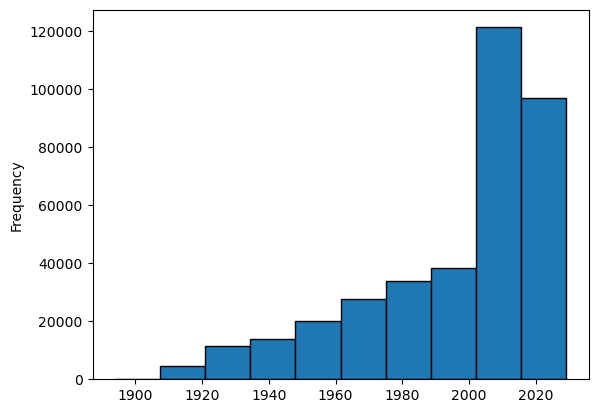

In [112]:
%matplotlib inline

#Histogram to figure out distribution of the movie years
title_basics_processed['startYear'].plot(kind='hist', edgecolor='black')

## Data Cleanup and Analysis using a Box Plot for Visualization <a name="data-boxplot"></a>

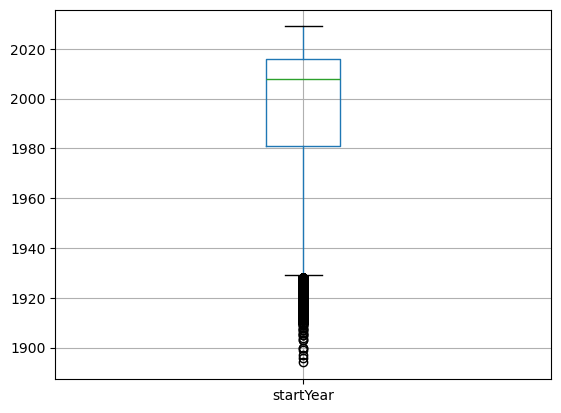

In [113]:
%matplotlib inline
# Box plot to figure out the distribution and remove outliers
title_basics_processed.boxplot(column='startYear', return_type='axes');

In [115]:
import numpy as np
# We'll only consider movies after 1939 
title_basics_processed = title_basics_processed[(title_basics_processed.startYear >= 1930) ]

#Convert year to float
title_basics_processed.startYear = title_basics_processed.startYear.apply(int)

In [116]:
import pandas as pd
title_basics_processed['runtimeMinutes'] = pd.to_numeric(title_basics_processed['runtimeMinutes'],errors='coerce')
title_basics_processed.dropna()
title_basics_processed.runtimeMinutes = title_basics_processed.runtimeMinutes.apply(int)

## Data Cleanup and Analysis using Binning for Visualization of runtime <a name="data-binning-runtime"></a>

/tmp/ipykernel_95/2573433867.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  title_basics_processed_visual.groupby('bins').size().plot(kind='bar')


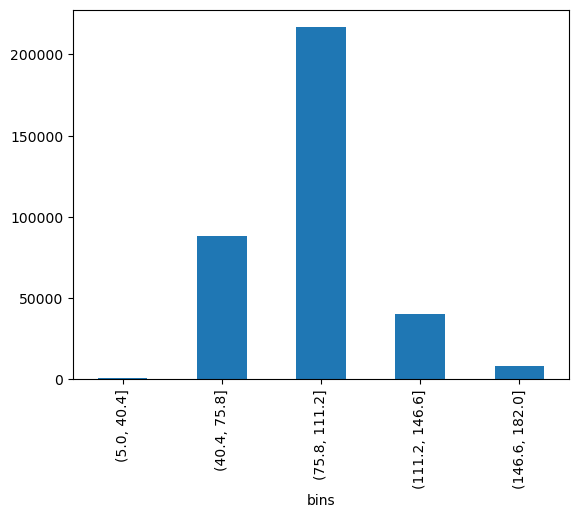

In [117]:

import matplotlib.pyplot as plt


title_basics_processed_visual = title_basics_processed

# create an array of bin edges based on runtimeMinutes. 
bin_edges = np.linspace(5, 182, num=6)
title_basics_processed_visual['bins'] = pd.cut(title_basics_processed_visual['runtimeMinutes'], bin_edges)
title_basics_processed_visual.groupby('bins').size().plot(kind='bar')
plt.show()


In [118]:
# So it seems like most of the runtimeMinutes is within 182 mins

title_basics_processed = title_basics_processed[title_basics_processed.runtimeMinutes <= 182]

## Data Transformation using One hot encoding of Movie Features <a name="one-hot-encoding"></a>

In [119]:
### transform genre CSV type feature to one-hot-encoding like columns for ML usage

genre_split = list(title_basics_processed.genres)
genre_split = ','.join(genre_split)
genre_split = genre_split.split(',')
genre_split = list(set(genre_split))
for k in genre_split:
    title_basics_processed[k] = 0
    
for k in title_basics_processed.index:
    x = title_basics_processed['genres'][k].split(',')
    for j in x:
        title_basics_processed[j][k] = 1
        
title_basics_processed = title_basics_processed.drop(columns = ["bins","genres"] )
title_basics_processed.head()


/tmp/ipykernel_95/2222731608.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  title_basics_processed[k] = 0
/tmp/ipykernel_95/2222731608.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  title_basics_processed[k] = 0
/tmp/ipykernel_95/2222731608.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.htm

,tconst,primaryTitle,originalTitle,startYear,runtimeMinutes,Documentary,War,History,Fantasy,Film-Noir,...,Romance,Sci-Fi,Crime,Biography,Short,Comedy,Game-Show,Mystery,Animation,Musical
3816,tt0003854,Dodge City Trail,Dodge City Trail,1936,56,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13082,tt0013274,Istoriya grazhdanskoy voyny,Istoriya grazhdanskoy voyny,2021,94,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15486,tt0015724,Dama de noche,Dama de noche,1993,102,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
15788,tt0016029,The Little Colonel,The Little Colonel,1935,81,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
17704,tt0017961,Happiness,Schaste,1935,95,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [120]:
title_basics_processed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 354916 entries, 3816 to 9811351
Data columns (total 33 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   tconst          354916 non-null  object
 1   primaryTitle    354916 non-null  object
 2   originalTitle   354916 non-null  object
 3   startYear       354916 non-null  int64 
 4   runtimeMinutes  354916 non-null  int64 
 5   Documentary     354916 non-null  int64 
 6   War             354916 non-null  int64 
 7   History         354916 non-null  int64 
 8   Fantasy         354916 non-null  int64 
 9   Film-Noir       354916 non-null  int64 
 10  News            354916 non-null  int64 
 11  Family          354916 non-null  int64 
 12  Thriller        354916 non-null  int64 
 13  Adventure       354916 non-null  int64 
 14  Horror          354916 non-null  int64 
 15  Reality-TV      354916 non-null  int64 
 16  Talk-Show       354916 non-null  int64 
 17  Action          354916 non-nul

## Data Transformation and visualization of Genres using Bar plots <a name="bar-plots"></a>

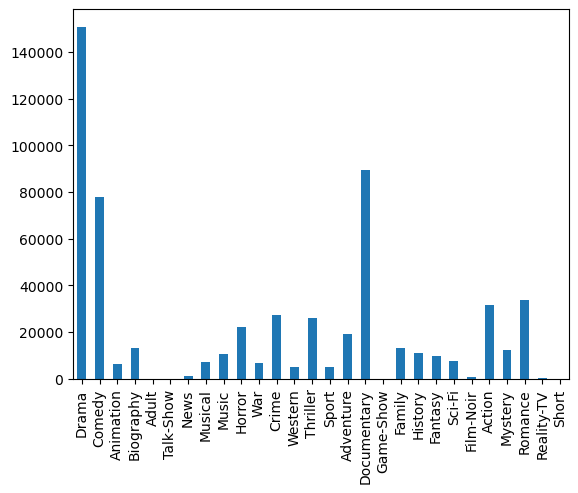

In [28]:
%matplotlib inline
import matplotlib.pyplot as plt


title_basics_processed[['Drama','Comedy','Animation','Biography',
                        'Adult','Talk-Show','News','Musical','Music',
                       'Horror','War','Crime','Western','Thriller','Sport',
                        'Adventure','Documentary','Game-Show','Family','History',
                       'Fantasy','Sci-Fi','Film-Noir','Action','Mystery','Romance','Reality-TV','Short']].sum().plot.bar()

plt.show()

## Additional Data Preparation steps <a name="additional-data-preparation"></a>

In [29]:
title_basics_processed = title_basics_processed.sort_index()
title_basics_processed = title_basics_processed.drop(columns= ['Short','Reality-TV','News','Game-Show','Talk-Show','Adult'])
title_basics_processed = title_basics_processed.dropna()
title_basics_processed.head()

,tconst,primaryTitle,originalTitle,startYear,runtimeMinutes,Documentary,War,History,Fantasy,Film-Noir,...,Western,Sport,Romance,Sci-Fi,Crime,Biography,Comedy,Mystery,Animation,Musical
3816,tt0003854,Dodge City Trail,Dodge City Trail,1936,56,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
13082,tt0013274,Istoriya grazhdanskoy voyny,Istoriya grazhdanskoy voyny,2021,94,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15486,tt0015724,Dama de noche,Dama de noche,1993,102,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
15788,tt0016029,The Little Colonel,The Little Colonel,1935,81,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
17704,tt0017961,Happiness,Schaste,1935,95,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


## Loading ratings dataset <a name="bar-plots"></a>

In [30]:
# this data set has ratings and votes
# We will now merge the attributes of the 2 data sets to have a holistic data 
title_ratings ='csv_files/csv_files/title.ratings.tsv'
obj = s3.get_object(Bucket = bucket_name,Key = title_ratings)
df_title_ratings = pd.read_table(obj['Body'])
df_title_ratings.dropna()
df_title_ratings.head()

,tconst,averageRating,numVotes
0,tt0000001,5.7,1966
1,tt0000002,5.8,263
2,tt0000003,6.5,1808
3,tt0000004,5.6,178
4,tt0000005,6.2,2607


## Merge ratings and basics datasets <a name="bar-plots"></a>

In [31]:
final = pd.merge(left=title_basics_processed, right=df_title_ratings, on='tconst')
final.shape

(247010, 29)

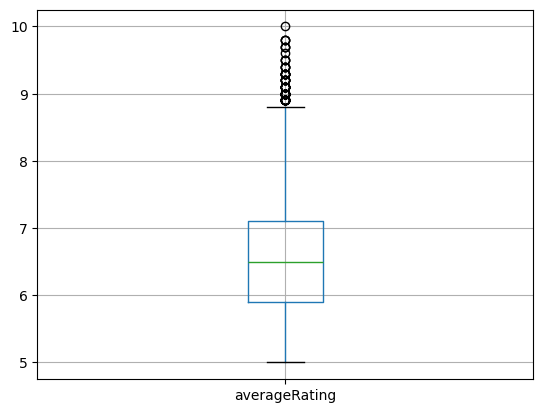

In [121]:
%matplotlib inline
final.boxplot(column='averageRating', return_type='axes');

In [122]:
#triming down votes to>=5
final = final[final.averageRating >= 5]
final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47150 entries, 0 to 47149
Data columns (total 26 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   startYear       47150 non-null  int64  
 1   runtimeMinutes  47150 non-null  int64  
 2   Thriller        47150 non-null  int64  
 3   Music           47150 non-null  int64  
 4   Documentary     47150 non-null  int64  
 5   Film-Noir       47150 non-null  int64  
 6   War             47150 non-null  int64  
 7   History         47150 non-null  int64  
 8   Animation       47150 non-null  int64  
 9   Biography       47150 non-null  int64  
 10  Horror          47150 non-null  int64  
 11  Adventure       47150 non-null  int64  
 12  Sport           47150 non-null  int64  
 13  Musical         47150 non-null  int64  
 14  Mystery         47150 non-null  int64  
 15  Action          47150 non-null  int64  
 16  Comedy          47150 non-null  int64  
 17  Sci-Fi          47150 non-null 

In [123]:

final.dropna()
min_value = final['numVotes'].min()
max_value = final['numVotes'].max()
print(min_value)
print(max_value)
 

500
2731760


/tmp/ipykernel_95/55803526.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  final_visual.groupby('bins').size().plot(kind='bar')


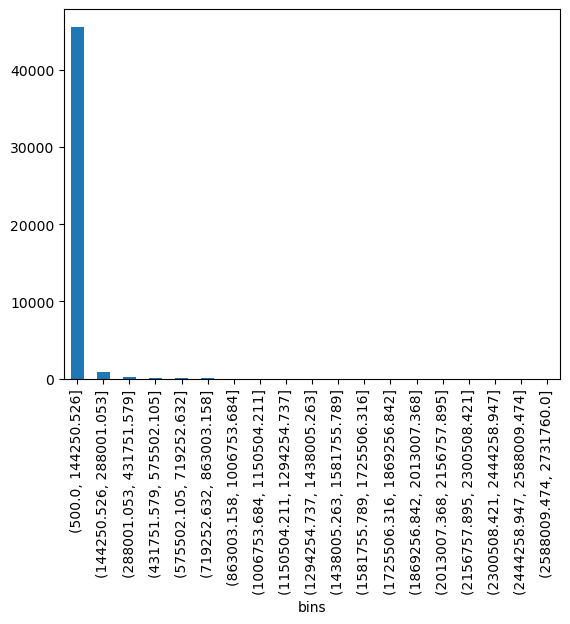

In [124]:
import matplotlib.pyplot as plt

# Lets analyze the distribution of the number of votes
# create a sample dataframe
final_visual = final

bin_edges = np.linspace(500, 2731760, num=20)

final_visual['bins'] = pd.cut(final_visual['numVotes'], bin_edges)

# use groupby and plot
final_visual.groupby('bins').size().plot(kind='bar')
plt.show()

In [37]:
final = final[(final.numVotes >= 500) ]
final.dropna()
final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47150 entries, 3 to 247008
Data columns (total 30 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   tconst          47150 non-null  object  
 1   primaryTitle    47150 non-null  object  
 2   originalTitle   47150 non-null  object  
 3   startYear       47150 non-null  int64   
 4   runtimeMinutes  47150 non-null  int64   
 5   Documentary     47150 non-null  int64   
 6   War             47150 non-null  int64   
 7   History         47150 non-null  int64   
 8   Fantasy         47150 non-null  int64   
 9   Film-Noir       47150 non-null  int64   
 10  Family          47150 non-null  int64   
 11  Thriller        47150 non-null  int64   
 12  Adventure       47150 non-null  int64   
 13  Horror          47150 non-null  int64   
 14  Action          47150 non-null  int64   
 15  Music           47150 non-null  int64   
 16  Drama           47150 non-null  int64   
 17  Western         

In [38]:
#sampling the data
final = final.sample(frac=1, random_state=42)
final = final.sort_index()
final = final.reset_index()
final.head()

,index,tconst,primaryTitle,originalTitle,startYear,runtimeMinutes,Documentary,War,History,Fantasy,...,Sci-Fi,Crime,Biography,Comedy,Mystery,Animation,Musical,averageRating,numVotes,bins
0,3,tt0016029,The Little Colonel,The Little Colonel,1935,81,0,0,0,0,...,0,0,0,1,0,0,0,7.0,1781,"(500.0, 144250.526]"
1,4,tt0017961,Happiness,Schaste,1935,95,0,0,0,0,...,0,0,0,1,0,0,0,7.3,1155,"(500.0, 144250.526]"
2,6,tt0019403,Salt for Svanetia,Jim Shvante (marili svanets),1930,55,1,0,0,0,...,0,0,0,0,0,0,0,7.5,829,"(500.0, 144250.526]"
3,12,tt0020163,People on Sunday,Menschen am Sonntag,1930,73,0,0,0,0,...,0,0,0,1,0,0,0,7.3,3329,"(500.0, 144250.526]"
4,15,tt0020298,Queen Kelly,Queen Kelly,1932,101,0,0,0,0,...,0,0,0,0,0,0,0,7.1,3302,"(500.0, 144250.526]"


In [39]:
#Removing bins and index columns
final=final.drop(['index','bins'], axis = 1)
final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47150 entries, 0 to 47149
Data columns (total 29 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   tconst          47150 non-null  object 
 1   primaryTitle    47150 non-null  object 
 2   originalTitle   47150 non-null  object 
 3   startYear       47150 non-null  int64  
 4   runtimeMinutes  47150 non-null  int64  
 5   Documentary     47150 non-null  int64  
 6   War             47150 non-null  int64  
 7   History         47150 non-null  int64  
 8   Fantasy         47150 non-null  int64  
 9   Film-Noir       47150 non-null  int64  
 10  Family          47150 non-null  int64  
 11  Thriller        47150 non-null  int64  
 12  Adventure       47150 non-null  int64  
 13  Horror          47150 non-null  int64  
 14  Action          47150 non-null  int64  
 15  Music           47150 non-null  int64  
 16  Drama           47150 non-null  int64  
 17  Western         47150 non-null 

In [40]:

movie_data = final[['tconst','primaryTitle','originalTitle']].copy()
final=final.drop(['tconst','primaryTitle','originalTitle'], axis = 1)
change_column = ['startYear','runtimeMinutes','Thriller','Music','Documentary','Film-Noir','War',
                 'History','Animation','Biography','Horror','Adventure',
                 'Sport','Musical','Mystery','Action','Comedy','Sci-Fi',
                 'Crime','Romance','Fantasy','Western','Drama','Family','averageRating','numVotes']
final = final.reindex(columns=change_column)


final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47150 entries, 0 to 47149
Data columns (total 26 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   startYear       47150 non-null  int64  
 1   runtimeMinutes  47150 non-null  int64  
 2   Thriller        47150 non-null  int64  
 3   Music           47150 non-null  int64  
 4   Documentary     47150 non-null  int64  
 5   Film-Noir       47150 non-null  int64  
 6   War             47150 non-null  int64  
 7   History         47150 non-null  int64  
 8   Animation       47150 non-null  int64  
 9   Biography       47150 non-null  int64  
 10  Horror          47150 non-null  int64  
 11  Adventure       47150 non-null  int64  
 12  Sport           47150 non-null  int64  
 13  Musical         47150 non-null  int64  
 14  Mystery         47150 non-null  int64  
 15  Action          47150 non-null  int64  
 16  Comedy          47150 non-null  int64  
 17  Sci-Fi          47150 non-null 

## Final Numerical FeatureSets in our Raw Data <a name="final-numerical-datasets"></a>

In [41]:

final.head()

,startYear,runtimeMinutes,Thriller,Music,Documentary,Film-Noir,War,History,Animation,Biography,...,Comedy,Sci-Fi,Crime,Romance,Fantasy,Western,Drama,Family,averageRating,numVotes
0,1935,81,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,7.0,1781
1,1935,95,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,7.3,1155
2,1930,55,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,7.5,829
3,1930,73,0,0,0,0,0,0,0,0,...,1,0,0,1,0,0,1,0,7.3,3329
4,1932,101,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,7.1,3302


In [42]:
# Check joblib version is 1.2.0
!pip show joblib

Name: joblib
Version: 1.3.2
Summary: Lightweight pipelining with Python functions
Home-page: 
Author: 
Author-email: Gael Varoquaux <gael.varoquaux@normalesup.org>
License: BSD 3-Clause
Location: /opt/conda/lib/python3.10/site-packages
Requires: 
Required-by: autogluon.timeseries, nltk, sacremoses, scikit-learn


## scaling our model locally and upload the model to S3 <a name="local-scaling"></a>

In [43]:

from sklearn.preprocessing import StandardScaler
import joblib as joblib

# create a scaler object
column_list = list(final.columns)
print(column_list)

scaler = StandardScaler()
scaler.fit(final)
joblib.dump(scaler, 'model.joblib')


df_final_standardized = scaler.transform(final).astype(np.float32) 

['startYear', 'runtimeMinutes', 'Thriller', 'Music', 'Documentary', 'Film-Noir', 'War', 'History', 'Animation', 'Biography', 'Horror', 'Adventure', 'Sport', 'Musical', 'Mystery', 'Action', 'Comedy', 'Sci-Fi', 'Crime', 'Romance', 'Fantasy', 'Western', 'Drama', 'Family', 'averageRating', 'numVotes']


In [44]:
# Upload the standard scalar model to the s3 bucket
session = boto3.Session()
s3 = session.client('s3')
role = get_execution_role()
scaler_key = 'model.joblib'
s3.upload_file('model.joblib', bucket_name, scaler_key)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


In [45]:
# Just for testing the output from my serialized local model i.e pkl file to see if I get back the correct responses
from pandas import json_normalize
import json
import joblib
model_trial = joblib.load("model.joblib")

print(column_list)


json_string = '{"startYear":[2015],"runtimeMinutes":[150],"Thriller":[1],"Music":[0],"Documentary":[0],"Film-Noir":[0],"War":[0],"History":[0],"Animation":[0],"Biography":[0],"Horror":[0],"Adventure":[1],"Sport":[0],"Musical":[0],"Mystery":[0],"Action":[1],"Comedy":[0],"Sci-Fi":[1],"Crime":[1],"Romance":[0],"Fantasy":[0],"Western":[0],"Drama":[0],"Family":[0],"averageRating":[7],"numVotes":[50]}'

# Convert the json string to a dictionary
json_dict = json.loads(json_string)

#and then to dataframe
json_dict_df = pd.DataFrame(json_dict)

# Scaling the model
json_dict_df_from_model = model_trial.transform(json_dict_df).astype('float32')
json_dict_df_from_model #this is numpy array

# convert to list
json_dict_df_from_model = json_dict_df_from_model.tolist()

# convert list to json
json_response = json.dumps(json_dict_df_from_model)
respJSON = {'Output': json_response}
respJSON

['startYear', 'runtimeMinutes', 'Thriller', 'Music', 'Documentary', 'Film-Noir', 'War', 'History', 'Animation', 'Biography', 'Horror', 'Adventure', 'Sport', 'Musical', 'Mystery', 'Action', 'Comedy', 'Sci-Fi', 'Crime', 'Romance', 'Fantasy', 'Western', 'Drama', 'Family', 'averageRating', 'numVotes']


{'Output': '[[0.7641384601593018, 2.2621326446533203, 2.6349685192108154, -0.19743624329566956, -0.27217793464660645, -0.10682649910449982, -0.17017419636249542, -0.20378568768501282, -0.18412098288536072, -0.2402506023645401, -0.29970091581344604, 3.0483622550964355, -0.14215995371341705, -0.14177125692367554, -0.27615731954574585, 2.3601934909820557, -0.7180797457695007, 5.349470615386963, 2.2987284660339355, -0.46801629662513733, -0.22049188613891602, -0.1328728199005127, -1.1882809400558472, -0.21341808140277863, 0.5960079431533813, -0.24598699808120728]]'}

In [46]:

df_final_standardized = pd.DataFrame(df_final_standardized)
df_final_standardized.columns = column_list
df_final_standardized.head()

,startYear,runtimeMinutes,Thriller,Music,Documentary,Film-Noir,War,History,Animation,Biography,...,Comedy,Sci-Fi,Crime,Romance,Fantasy,Western,Drama,Family,averageRating,numVotes
0,-2.696403,-1.132088,-0.379511,5.064926,-0.272178,-0.106826,-0.170174,-0.203786,-0.184121,-0.240251,...,1.392603,-0.186934,-0.435023,-0.468016,-0.220492,-0.132873,-1.188281,4.685638,0.596008,-0.225267
1,-2.696403,-0.443406,-0.379511,-0.197436,-0.272178,-0.106826,-0.170174,-0.203786,-0.184121,-0.240251,...,1.392603,-0.186934,-0.435023,-0.468016,-0.220492,-0.132873,0.841552,-0.213418,0.970587,-0.232760
2,-2.912687,-2.411070,-0.379511,-0.197436,3.674067,-0.106826,-0.170174,-0.203786,-0.184121,-0.240251,...,-0.718080,-0.186934,-0.435023,-0.468016,-0.220492,-0.132873,-1.188281,-0.213418,1.220306,-0.236662
3,-2.912687,-1.525621,-0.379511,-0.197436,-0.272178,-0.106826,-0.170174,-0.203786,-0.184121,-0.240251,...,1.392603,-0.186934,-0.435023,2.136678,-0.220492,-0.132873,0.841552,-0.213418,0.970587,-0.206737
4,-2.826174,-0.148256,-0.379511,-0.197436,-0.272178,-0.106826,-0.170174,-0.203786,-0.184121,-0.240251,...,-0.718080,-0.186934,-0.435023,-0.468016,-0.220492,-0.132873,0.841552,-0.213418,0.720868,-0.207060


## KMeans Clustering Model - Train, build and deploy on sagemaker <a name="kmeans"></a>

In [47]:


from sagemaker import KMeans
kmeans = KMeans(role=role,
                instance_count=1,
                instance_type='ml.c4.xlarge',
                output_path='s3://'+ bucket_name + '/',
                init_method='kmeans++',
                k=26, 
                epochs=5)
kmeans.fit(kmeans.record_set(df_final_standardized.values))

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating training-job with name: kmeans-2023-12-11-16-52-35-734


2023-12-11 16:52:35 Starting - Starting the training job......
2023-12-11 16:53:11 Starting - Preparing the instances for training......
2023-12-11 16:54:22 Downloading - Downloading input data...
2023-12-11 16:54:57 Training - Downloading the training image......
2023-12-11 16:56:03 Training - Training image download completed. Training in progress...Docker entrypoint called with argument(s): train
Running default environment configuration script
[12/11/2023 16:56:12 INFO 140128218048320] Reading default configuration from /opt/amazon/lib/python3.8/site-packages/algorithm/resources/default-input.json: {'init_method': 'random', 'mini_batch_size': '5000', 'epochs': '1', 'extra_center_factor': 'auto', 'local_lloyd_max_iter': '300', 'local_lloyd_tol': '0.0001', 'local_lloyd_init_method': 'kmeans++', 'local_lloyd_num_trials': 'auto', 'half_life_time_size': '0', 'eval_metrics': '["msd"]', 'force_dense': 'true', '_disable_wait_to_read': 'false', '_enable_profiler': 'false', '_kvstore': 'auto

In [48]:
#Model deployment

kmeans_predictor = kmeans.deploy(initial_instance_count=1, instance_type='ml.m5.large')

INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating model with name: kmeans-2023-12-11-16-57-06-783
INFO:sagemaker:Creating endpoint-config with name kmeans-2023-12-11-16-57-06-783
INFO:sagemaker:Creating endpoint with name kmeans-2023-12-11-16-57-06-783


------!

## Save the enhanced dataset in Glue <a name="glue"></a> 

In [49]:
df_final_standardized.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47150 entries, 0 to 47149
Data columns (total 26 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   startYear       47150 non-null  float32
 1   runtimeMinutes  47150 non-null  float32
 2   Thriller        47150 non-null  float32
 3   Music           47150 non-null  float32
 4   Documentary     47150 non-null  float32
 5   Film-Noir       47150 non-null  float32
 6   War             47150 non-null  float32
 7   History         47150 non-null  float32
 8   Animation       47150 non-null  float32
 9   Biography       47150 non-null  float32
 10  Horror          47150 non-null  float32
 11  Adventure       47150 non-null  float32
 12  Sport           47150 non-null  float32
 13  Musical         47150 non-null  float32
 14  Mystery         47150 non-null  float32
 15  Action          47150 non-null  float32
 16  Comedy          47150 non-null  float32
 17  Sci-Fi          47150 non-null 

In [50]:
prediction_data1 = df_final_standardized[0:40000]
prediction_data2 = df_final_standardized[40000:47150]

result1=kmeans_predictor.predict(prediction_data1.values)
result2=kmeans_predictor.predict(prediction_data2.values)

result = result1 + result2 

In [51]:
cluster_labels = [r.label['closest_cluster'].float32_tensor.values[0] for r in result]
predictions = pd.DataFrame(data=cluster_labels)
predictions.info

<bound method DataFrame.info of           0
0      13.0
1       9.0
2       3.0
3       9.0
4       9.0
...     ...
47145  14.0
47146   1.0
47147   1.0
47148   2.0
47149  19.0

[47150 rows x 1 columns]>

In [52]:
#displaying the list of columns
column_list

['startYear',
 'runtimeMinutes',
 'Thriller',
 'Music',
 'Documentary',
 'Film-Noir',
 'War',
 'History',
 'Animation',
 'Biography',
 'Horror',
 'Adventure',
 'Sport',
 'Musical',
 'Mystery',
 'Action',
 'Comedy',
 'Sci-Fi',
 'Crime',
 'Romance',
 'Fantasy',
 'Western',
 'Drama',
 'Family',
 'averageRating',
 'numVotes']

In [53]:

pred_info = pd.concat([predictions, final], axis=1)
pred_info = pred_info.rename(columns={0: 'cluster'})
pred_final = pd.concat([movie_data, pred_info], axis=1)
pred_final

,tconst,primaryTitle,originalTitle,cluster,startYear,runtimeMinutes,Thriller,Music,Documentary,Film-Noir,...,Comedy,Sci-Fi,Crime,Romance,Fantasy,Western,Drama,Family,averageRating,numVotes
0,tt0016029,The Little Colonel,The Little Colonel,13.0,1935,81,0,1,0,0,...,1,0,0,0,0,0,0,1,7.0,1781
1,tt0017961,Happiness,Schaste,9.0,1935,95,0,0,0,0,...,1,0,0,0,0,0,1,0,7.3,1155
2,tt0019403,Salt for Svanetia,Jim Shvante (marili svanets),3.0,1930,55,0,0,1,0,...,0,0,0,0,0,0,0,0,7.5,829
3,tt0020163,People on Sunday,Menschen am Sonntag,9.0,1930,73,0,0,0,0,...,1,0,0,1,0,0,1,0,7.3,3329
4,tt0020298,Queen Kelly,Queen Kelly,9.0,1932,101,0,0,0,0,...,0,0,0,0,0,0,1,0,7.1,3302
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47145,tt9907782,The Cursed,Eight for Silver,14.0,2021,111,0,0,0,0,...,0,0,0,0,1,0,0,0,6.2,12808
47146,tt9908390,Le lion,Le lion,1.0,2020,95,0,0,0,0,...,1,0,0,0,0,0,0,0,5.4,1285
47147,tt9911196,The Marriage Escape,De beentjes van Sint-Hildegard,1.0,2020,103,0,0,0,0,...,1,0,0,0,0,0,1,0,7.5,2890
47148,tt9916270,Il talento del calabrone,Il talento del calabrone,2.0,2020,84,1,0,0,0,...,0,0,0,0,0,0,0,0,5.8,1418


In [129]:
#Predictions
data_to_predict1 = {"startYear":[1970], "runtimeMinutes":[150],"Thriller":[0],"Music":[0],"Documentary":[0],
                    "Film-Noir":[0],"War":[0],"History":[0],"Animation":[1],"Biography":[0],
                    "Horror":[0],"Adventure":[0],"Sport":[0],"Musical":[0],
                    "Mystery":[0],"Action":[0],"Comedy":[0],"Sci-Fi":[0],
                    "Crime":[0],"Romance":[0],"Fantasy":[0],"Western":[0],
                    "Drama":[0],"Family":[0],
                    "averageRating":[7],"numVotes":[50]}

in_data2 = pd.DataFrame(data_to_predict1)
input2 = scaler.transform(in_data2).astype('float32')
input2_pred = kmeans_predictor.predict(input2)
input2_cluster = [r.label['closest_cluster'].float32_tensor.values[0] for r in input2_pred]
#predicted cluster 
print(int(input2_cluster[0]))

20


In [ ]:
#top 10 recomendations sorted based on number of votes and averageRating 
recommendations = pred_final.loc[pred_final['cluster'] == 
            int(input2_cluster[0])].sort_values(by =['numVotes','averageRating'], ascending=False)[:10]
recommendations

In [131]:
data_to_predict2 = {"startYear":[1990], "runtimeMinutes":[150],"Thriller":[0],"Music":[0],"Documentary":[1],
                    "Film-Noir":[0],"War":[0],"History":[0],"Animation":[0],"Biography":[1],
                    "Horror":[0],"Adventure":[0],"Sport":[1],"Musical":[0],
                    "Mystery":[0],"Action":[0],"Comedy":[0],"Sci-Fi":[0],
                    "Crime":[0],"Romance":[0],"Fantasy":[0],"Western":[0],
                    "Drama":[0],"Family":[0],
                    "averageRating":[7],"numVotes":[50]}

in_data3 = pd.DataFrame(data_to_predict2)
input3 = scaler.transform(in_data3).astype('float32')
input3_pred = kmeans_predictor.predict(input3)
input3_cluster = [r.label['closest_cluster'].float32_tensor.values[0] for r in input3_pred]
#predicted cluster 
print(int(input3_cluster[0]))

16


In [132]:
recommendations = pred_final.loc[pred_final['cluster'] == 
            int(input3_cluster[0])].sort_values(by =['numVotes','averageRating'], ascending=False)[:15]
recommendations

,tconst,primaryTitle,originalTitle,cluster,startYear,runtimeMinutes,Thriller,Music,Documentary,Film-Noir,...,Comedy,Sci-Fi,Crime,Romance,Fantasy,Western,Drama,Family,averageRating,numVotes
8766,tt0075148,Rocky,Rocky,16.0,1976,120,0,0,0,0,...,0,0,0,0,0,0,1,0,8.1,595442
29272,tt1291584,Warrior,Warrior,16.0,2011,140,0,0,0,0,...,0,0,0,0,0,0,1,0,8.2,480407
28423,tt1210166,Moneyball,Moneyball,16.0,2011,133,0,0,0,0,...,0,0,0,0,0,0,1,0,7.6,436612
9780,tt0081398,Raging Bull,Raging Bull,16.0,1980,129,0,0,0,0,...,0,0,0,0,0,0,1,0,8.1,361511
25050,tt0878804,The Blind Side,The Blind Side,16.0,2009,129,0,0,0,0,...,0,0,0,0,0,0,1,0,7.6,342499
27331,tt1125849,The Wrestler,The Wrestler,16.0,2008,109,0,0,0,0,...,0,0,0,0,0,0,1,0,7.9,312167
37795,tt3076658,Creed,Creed,16.0,2015,133,0,0,0,0,...,0,0,0,0,0,0,1,0,7.6,294865
21050,tt0364725,Dodgeball: A True Underdog Story,Dodgeball: A True Underdog Story,16.0,2004,92,0,0,0,0,...,1,0,0,0,0,0,0,0,6.7,256644
15135,tt0116483,Happy Gilmore,Happy Gilmore,16.0,1996,92,0,0,0,0,...,1,0,0,0,0,0,0,0,7.0,233949
23775,tt0479143,Rocky Balboa,Rocky Balboa,16.0,2006,102,0,0,0,0,...,0,0,0,0,0,0,1,0,7.1,223703


In [44]:
# We do the steps below, so that the dataframe "pred_final" holding the final predictions - clusters is saved to a database

In [45]:
!pip install awswrangler

  Using cached awswrangler-3.4.2-py3-none-any.whl.metadata (23 kB)
Using cached awswrangler-3.4.2-py3-none-any.whl (396 kB)


In [51]:
import awswrangler as wr
path = f"s3://{bucket_name}/clusteredfinaldata/"
wr.s3.to_parquet(
    df=pred_final,
    path=path,
    dataset=True,
    database="movie-rec-db",
    table="clusters"
);

In [73]:
col_names = ["tconst", "primarytitle", "originaltitle", "cluster", "startyear", "runtimeminutes", "thriller", "music",
            "documentary","film_noir","war","history","animation","biography","horror","adventure","sport","musical","mystery",
            "action","comedy","sci_fi","crime","romance","fantasy","western","drama","family","averagerating","numvotes"]


sql = """
SELECT
    *
FROM "movie-rec-db".clusters
WHERE cluster =:x order by averagerating , numvotes asc limit 10
"""

df = wr.athena.read_sql_query(sql, params={"x": 5} , database="movie-rec-db")

INFO:awswrangler.athena._utils:Created CTAS table "movie-rec-db"."temp_table_298c3001c5ca48b0be9babe2a8392133"


In [74]:
df

,tconst,primarytitle,originaltitle,cluster,startyear,runtimeminutes,thriller,music,documentary,film_noir,...,comedy,sci_fi,crime,romance,fantasy,western,drama,family,averagerating,numvotes
0,tt0119931,Standoff,Standoff,5.0,1998,91,1,0,0,0,...,0,0,0,0,0,0,0,0,5.0,516
1,tt0043019,This Can't Happen Here,Sånt händer inte här,5.0,1950,84,1,0,0,0,...,0,0,0,0,0,0,1,0,5.0,519
2,tt3239154,Zoe Gone,Zoe Gone,5.0,2014,88,0,0,0,0,...,0,0,1,0,0,0,1,0,5.0,526
3,tt0093539,Million Dollar Mystery,Million Dollar Mystery,5.0,1987,95,0,0,0,0,...,1,0,0,0,0,0,0,0,5.0,533
4,tt6849128,An Elephant's Journey,Phoenix Wilder and the Great Elephant Adventure,5.0,2017,87,0,0,0,0,...,0,0,0,0,0,0,0,0,5.0,585
5,tt1470021,Beautiful Wave,Beautiful Wave,5.0,2011,96,0,0,0,0,...,0,0,0,0,0,0,1,0,5.0,599
6,tt0122785,Viola Kisses Everybody,Viola bacia tutti,5.0,1998,93,0,0,0,0,...,1,0,0,0,0,0,0,0,5.0,600
7,tt1180333,Blackout,Blackout,5.0,2008,108,1,0,0,0,...,0,0,0,0,0,0,0,0,5.0,609
8,tt14039346,Murder Party,Murder Party,5.0,2022,103,0,0,0,0,...,1,0,0,0,0,0,0,0,5.0,618
9,tt8525070,Savage,Les fauves,5.0,2018,83,1,0,0,0,...,0,0,0,0,0,0,1,0,5.0,631
